In [3]:
# Importing the neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, RocCurveDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize, LabelBinarizer


import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


import keras_tuner

## Reading the data

In [4]:
df = pd.read_csv("processed_data.csv")
df.head()

,type,breed,color,sex,size,intake_type,intake_subtype,intake_condition,intake_jurisdiction,intake_total,age,intake_date,days_in_shelter,has_name,outcome_type
0,1,650,293,3,5,6,3,3,11,1,2,1688515200,34,1,ADOPTION
1,0,409,218,3,0,6,20,3,9,1,0,1685404800,70,1,ADOPTION
2,0,409,94,0,4,6,20,3,11,1,3,1689379200,24,1,TRANSFER
3,1,805,293,2,4,6,3,3,11,1,4,1682380800,85,1,ADOPTION
4,1,829,153,1,4,6,20,0,9,1,0,1691452800,0,1,RETURN TO OWNER


In [5]:
df.columns

Index(['type', 'breed', 'color', 'sex', 'size', 'intake_type',
       'intake_subtype', 'intake_condition', 'intake_jurisdiction',
       'intake_total', 'age', 'intake_date', 'days_in_shelter', 'has_name',
       'outcome_type'],
      dtype='object')

In [9]:
df['outcome_type'].value_counts()

RETURN TO OWNER    8606
ADOPTION           7533
TRANSFER           5439
EUTHANIZE          3552
DISPOSAL            235
DIED                171
RTOS                 49
ESCAPED/STOLEN       17
Name: outcome_type, dtype: int64

## Splitting the data by the predictor variables and the target variable

In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Splitting the data into train and test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

## Neural Network

In [25]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

In [26]:
X_train

array([[ 0.44506521,  1.06000611, -0.95301818, ...,  0.27339749,
        -0.32613948,  0.59627986],
       [ 0.44506521,  1.90450591,  0.8994607 , ...,  0.04549128,
        -0.06703585,  0.59627986],
       [ 0.44506521, -1.42536118, -1.2524087 , ..., -1.43085692,
        -0.18219302,  0.59627986],
       ...,
       [-1.20447886, -0.4145868 , -0.5413562 , ...,  1.14569338,
         0.1056999 ,  0.59627986],
       [ 0.44506521,  2.14954213,  1.51695365, ...,  0.37424094,
        -0.49887523,  0.59627986],
       [ 2.09460928, -1.09281203,  1.77892036, ...,  1.82941201,
        -0.32613948, -1.67706486]])

In [21]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows 
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train

array([5, 0, 7, ..., 0, 5, 5])

In [6]:
tf.keras.backend.clear_session()

loss_function = 'sparse_categorical_crossentropy'
optimizer = 'adam'
batch_size = 512
no_epochs = 10
verbosity = 1
num_folds = 5

In [74]:
def call_existing_code(units, activation, dropout, lr):
    model = Sequential()
    
    model.add(Dense(units=units*8, input_shape=(14,), activation=activation))
    
    if dropout:
        model.add(Dropout(rate=0.25))

    model.add(Dense(units=units*4, activation=activation))
    if dropout:
        model.add(Dropout(rate=0.25))

    model.add(Dense(units=units*2,  activation=activation))
    model.add(Dense(units=units, activation=activation))
    if dropout:
        model.add(Dropout(rate=0.25))
        
    model.add(Dense(8, activation="softmax"))
    
    model.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model


def build_model(hp):
    units = hp.Int("units", min_value=16, max_value=128, step=32) # 2^7 : 128
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units=units, activation=activation, dropout=dropout, lr=lr
    )
    return model


build_model(keras_tuner.HyperParameters())

In [75]:
tf.keras.backend.clear_session()

In [77]:
tuner_M2 = keras_tuner.Hyperband(hypermodel=build_model,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='hyperband-M7',
                     project_name='Animal_shelter')

tuner_M2.search_space_summary()

tuner_M2.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose = 1)

tuner_M2.results_summary()

Trial 90 Complete [00h 00m 44s]
val_accuracy: 0.8303065896034241

Best val_accuracy So Far: 0.8314782381057739
Total elapsed time: 00h 15m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in hyperband-M7\Animal_shelter
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0083 summary
Hyperparameters:
units: 48
activation: relu
dropout: False
lr: 0.0004508487014229573
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0081
Score: 0.8314782381057739

Trial 0089 summary
Hyperparameters:
units: 48
activation: relu
dropout: True
lr: 0.000483038152387294
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8303065896034241

Trial 0072 summary
Hyperparameters:
units: 112
activation: tanh
dropout: True
lr: 0.0012512429464290153
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0069
Score: 0.8295254707336426

Trial 0084 summary
Hyperparameters:
units

In [81]:
# get top model from hyperband
models = tuner_M2.get_best_models(num_models=1)
Model_2 = models[0]

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
Model_2.build(input_shape=(14,))
Model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 384)               5760      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_2 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_3 (Dense)              (None, 48)                4656      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 392       
Total params: 103,256
Trainable params: 103,256
Non-trainable params: 0
_________________________________________________________________


In [82]:
tf.keras.backend.clear_session()

In [83]:
# Get the optimal hyperparameters
best_hps=tuner_M2.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
Model_2 = tuner_M2.hypermodel.build(best_hps)
history = Model_2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose = 1)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
641/641 [==============================] - 1s 2ms/step - loss: 0.7467 - accuracy: 0.7405 - val_loss: 0.6550 - val_accuracy: 0.7563
Epoch 2/30
641/641 [==============================] - 1s 2ms/step - loss: 0.5874 - accuracy: 0.7966 - val_loss: 0.5892 - val_accuracy: 0.7922
Epoch 3/30
641/641 [==============================] - 1s 2ms/step - loss: 0.5494 - accuracy: 0.8086 - val_loss: 0.5704 - val_accuracy: 0.8020
Epoch 4/30
641/641 [==============================] - 1s 2ms/step - loss: 0.5227 - accuracy: 0.8177 - val_loss: 0.5615 - val_accuracy: 0.8047
Epoch 5/30
641/641 [==============================] - 1s 2ms/step - loss: 0.5085 - accuracy: 0.8209 - val_loss: 0.5559 - val_accuracy: 0.8073
Epoch 6/30
641/641 [==============================] - 1s 2ms/step - loss: 0.4944 - accuracy: 0.8256 - val_loss: 0.5474 - val_accuracy: 0.8051
Epoch 7/30
641/641 [==============================] - 1s 2ms/step - loss: 0.4787 - accuracy: 0.8316 - val_loss: 0.5391 - val_accuracy: 0.8133
Epoch 

In [84]:
# Evaluation 
score = Model_2.evaluate(X_test, y_test)
print("Validation Accuracy : {}".format(score[1]))

161/161 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 0.8147
Validation Accuracy : 0.8146846294403076


In [87]:
df_history = pd.DataFrame(history.history)
df_history.head(3)

,loss,accuracy,val_loss,val_accuracy
0,0.746733,0.740491,0.654996,0.756298
1,0.587390,0.796641,0.589224,0.792228
2,0.549441,0.808554,0.570382,0.801992


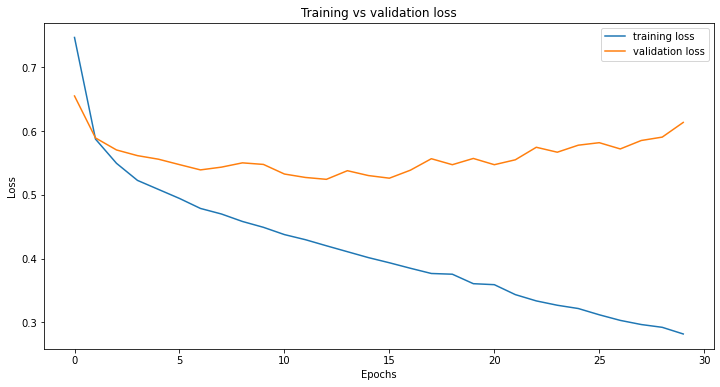

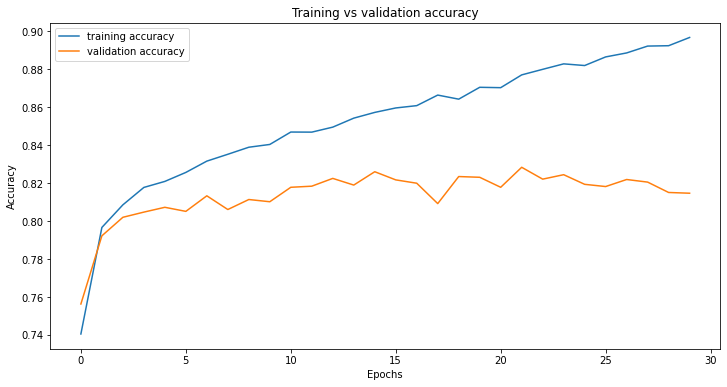

In [88]:
epochs = range(len(df_history['loss']))

plt.figure(figsize = (12,6))
plt.plot(epochs, df_history['loss'], label = 'training loss')
plt.plot(epochs, df_history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs validation loss")
plt.show()



plt.figure(figsize = (12,6))
plt.plot(epochs, df_history['accuracy'], label = 'training accuracy')
plt.plot(epochs, df_history['val_accuracy'], label = 'validation accuracy')
plt.legend(loc = 'best')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs validation accuracy")
plt.show()

In [89]:
ypred = Model_2.predict(X_test)
ypred = ypred.argmax(axis=-1)

In [86]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'ADOPTION': 0, 'DIED': 1, 'DISPOSAL': 2, 'ESCAPED/STOLEN': 3, 'EUTHANIZE': 4, 'RETURN TO OWNER': 5, 'RTOS': 6, 'TRANSFER': 7}


ROC AUC score: 0.7259995717363369


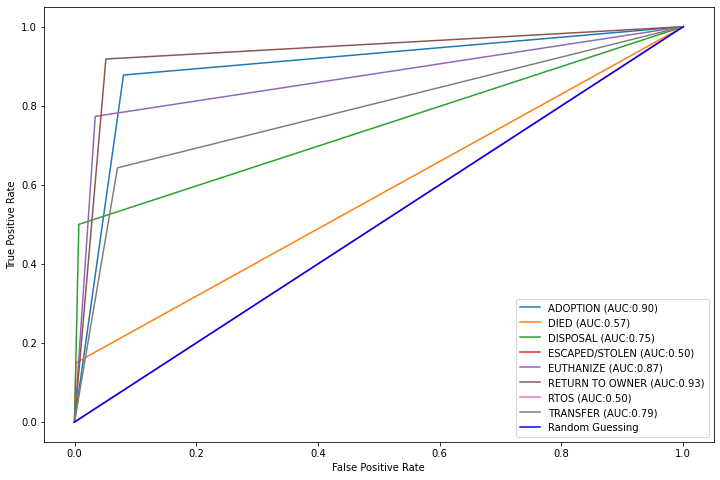

In [91]:
target= ['ADOPTION', 'DIED', 'DISPOSAL', 'ESCAPED/STOLEN', 'EUTHANIZE', 'RETURN TO OWNER', 'RTOS', 'TRANSFER']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [92]:
# Save the model
Model_2.save("Neural_network.h5")

print("Model saved successfully.")

Model saved successfully.
